# Tutorial 5: RJMCMC with Eryn

In the fifth tutorial, we will look at running Eryn when the underlying model is changing. This means we will be using Reversible-Jump MCMC, also referred to as trans-dimensional MCMC. In this tutorial, there will only be 2 tasks because RJMCMC is complicated and putting together an RJMCMC run takes time and effort. 

在第五个教程中，我们将了解在底层模型发生变化时如何运行Eryn。这意味着我们将使用可逆跳跃MCMC，也可以成为跨维度MCMC。在这个教程中只有两个任务，因为RJMCMC非常复杂，并且将RJMCMC一起运行需要很多时间和精力。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

## Task 1: How many Gaussian pulses?

The first RJ problem we will look at is determining how many 2D Gaussian pulses exist in a noisy set of data. This is an example you can find in the more advanced Eryn tutorials. To keep this simple in the time we have alotted, we will use a proposal based on the prior distribution (this is the default). If you set `rj_moves=True` in the setup of `EnsembleSampler`, it will automatically generate RJ proposals from the prior. However, you must be careful when using multiple branches (model types) because this proposal, by default, always proposes to change each model in the sampler by 1 model count, either add or remove. 

我们要看的第一个RJ问题是确定在一组包含噪声的数据中存在多少个二维的高斯脉冲。这个例子可以在更高级的Eryn教程中找到。为了在我们已分配的时间里保持问题简单，我们将使用先验分布的建议(事实上是默认值)。如果在EnsembleSampler设置rj_moves=True，它将自动从先验生成提案。然而，在使用多个分支(模型类型)时必须要小心，在默认情况下总是会建议将采样器中的每个模型更改1个模型计数，添加或者删除。

Useful documentation 参考文档:
* [EnsembleSampler](https://mikekatz04.github.io/Eryn/html/user/ensemble.html#eryn.ensemble.EnsembleSampler)
* [State](https://mikekatz04.github.io/Eryn/html/user/state.html#eryn.state.State)
* [uniform_dist](https://mikekatz04.github.io/Eryn/html/user/prior.html#eryn.prior.uniform_dist)
* [ProbDistContainer](https://mikekatz04.github.io/Eryn/html/user/prior.html#eryn.prior.ProbDistContainer)
* [GaussianMove](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.GaussianMove)
* [DistributionGenerateRJ](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.DistributionGenerateRJ)

In [2]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.moves import GaussianMove
from eryn.backends import HDFBackend
from chainconsumer import ChainConsumer, Chain

We will do the initial setup for you. Here we are going to set the x and y dimensions of our 2D grid.

我们为你准备好了初始化，这里我们设置了二维网格的x以及y维度。

In [3]:
num     = 100 # the number of step for each dimension
lowlim  = -10 # Low limit on each axis
highlim = 10  # high limit on each axis
npulses = 10  # The # of injected pulses

dx = (highlim - lowlim) / num # Get the discritization

x, y = np.mgrid[lowlim:highlim:dx, lowlim:highlim:dx]  # Generate the grid

Now, we will draw initial parameters for each set of pules. Each pulse gets an amplitude, x, and y value.

现在我们将为每组脉冲绘制初始参数。每个脉冲都有一个振幅，x值和y值。

In [4]:
Amp    = np.random.uniform(.5, 2.0, size=(npulses)) # Draw an amplitude
spread = .2  # Keep their spread as fixed for simplicity.
sigma  = spread * np.diag(np.ones(2))

edges = 2 # Utility parameter, in order to avoid having signals at the border of our data set

# Draw the coordinates parameters
# generates random x and y coordinates
inj_coordinates = np.random.uniform(lowlim+edges, highlim-edges, size=(npulses, 2))

# Gather all parameters here
gauss_inj_params = np.concatenate([Amp[:, None], inj_coordinates], axis=1)

print(' * Parameters injected: \n\n', np.matrix(gauss_inj_params))

 * Parameters injected: 

 [[ 0.69866898  2.10650861 -2.4016849 ]
 [ 1.08066052  7.75317038 -2.08403087]
 [ 1.75182684 -3.80581863  2.94351415]
 [ 1.35628499 -1.46612834  1.732191  ]
 [ 0.60821426  2.6249447  -4.73368266]
 [ 0.77939677 -0.26722571  6.55689935]
 [ 0.88488706 -5.07777902 -7.82257878]
 [ 0.79781648 -1.62780021  5.46651036]
 [ 0.76975255 -0.1201848  -6.8879106 ]
 [ 1.10274826 -4.31310468  5.9138313 ]]


We have also filled in the Gaussian function and Likelihood to avoid any issues. The next few cells give an idea of the injection data. 

我们还填充了高斯函数和似然以避免任何问题。接下来的几个单元格给出了注射数据的概念。

In [5]:
# First we compute some constant terms of the Gaussian models (reminder: we have assumed a fixed spread for each pulse)
sigma_det = np.linalg.det(sigma)
sigma_inv = np.linalg.inv(sigma)
norm      = np.sqrt((2*np.pi)**2 * sigma_det)

def gaussian(X, Y, a, b, c):
    x = X[:,0]
    y = Y[0,:]
    # breakpoint()
    A = np.exp(-((x[None, :] - b[:, None]) ** 2) / (2 * sigma[0,0]))
    B = np.exp(-((y[None, :] - c[:, None]) ** 2) / (2 * sigma[1,1]))
    # breakpoint()
    C =  A[:, None, :] * B[:, :, None] # (np.expand_dims(A,axis=0) * np.expand_dims(np.transpose(B),axis=2))

    return a[:, None, None] * C / norm

def log_prob_fn(x1, X, Y, data, sig):

    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]
    n = num * num

    template  = np.sum(gaussian(X, Y, a, b, c), axis=0)

    llh = - 0.5 * ( np.sum(((template - data)) ** 2) )
    llh *= 1/sig**2
    llh += - n*np.log(sig) - .5 * n * np.log(2.*np.pi)
    return llh

In [6]:
noise = spread * np.random.randn( num, num ) # Draw the random points for the noise

# Generate the data-set
injection = np.zeros( (num, num) )
injection = np.sum(gaussian(x, y, gauss_inj_params[:, 0], gauss_inj_params[:, 1], gauss_inj_params[:, 2]), axis=0)
data = injection + noise


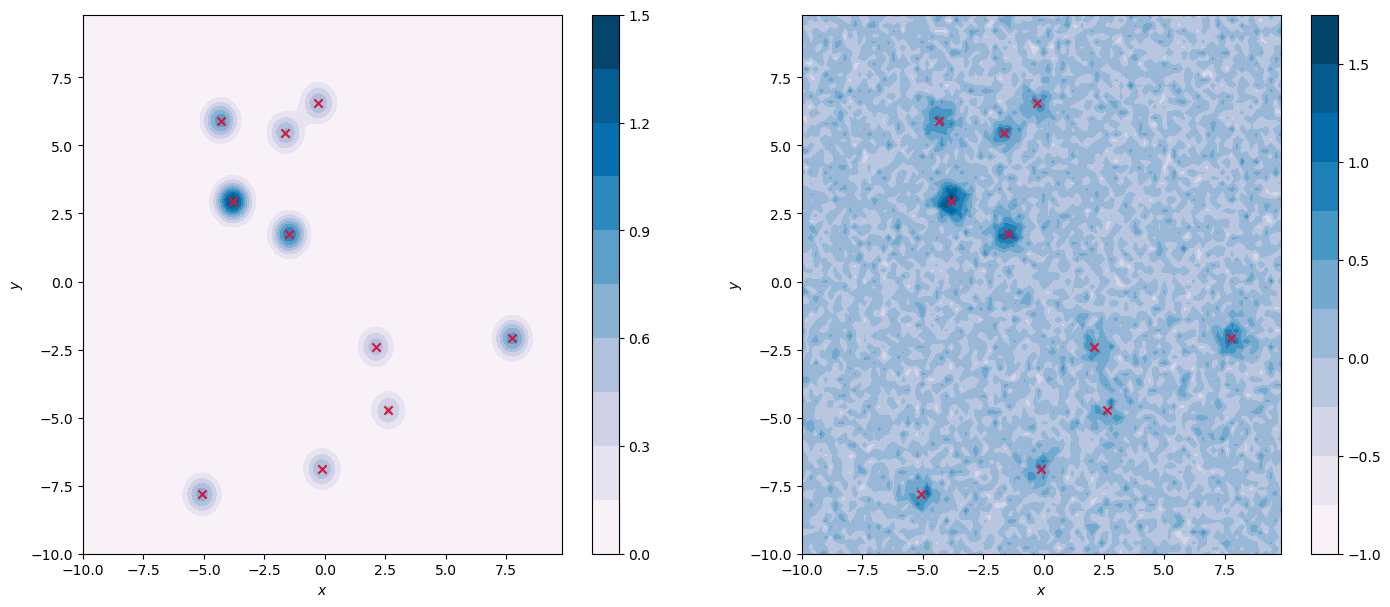

In [8]:
from matplotlib import cm

plt.figure(figsize=(17,7))
plt.subplot(121)
cf = plt.contourf(y, x, injection, 10, cmap=cm.PuBu)
plt.scatter(gauss_inj_params[:,1], gauss_inj_params[:,2], marker='x', color='#DC143C')
plt.colorbar(cf)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.subplot(122)
cf = plt.contourf(y, x, data, 10, cmap=cm.PuBu)
plt.scatter(gauss_inj_params[:,1], gauss_inj_params[:,2], marker='x', color='#DC143C')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(cf)
plt.show()


Now that we have most of the initial setup. We now need to build our sampling run. Let's start by choosing settings and building base requirements: `ndims`, `nleaves_max`, `nleaves_min`, `branch_names`, `ntemps`, `nwalkers`.

现在我们已经完成了大部分初始设置，需要构建我们的采样使其运行。让我们从选择设置和构建的基础开始。

In [9]:
ntemps = 10
nwalkers = 30

ndims        = {"pulse": 3}           # The dimensions of the two models we sample for here (# of parameter for each pulse, and # of parameters for the noise)
nleaves_max  = {"pulse": 2*npulses}   # Maximum number of components for each model type (noise is 1, because we don't want to use RJ MCMC on it).
nleaves_min = {"pulse": 0}
branch_names = ["pulse"]

Now we will setup our prior function. Make sure you initialize your prior with the `ProbDistContainer` object from Eryn. 
* For the amplitude, a uniform prior from 0.5 to 2.0.
* For x and y, uniform priors across the acceptable ranges.

现在我们要设置我们的先验方程。确保已经使用Eryn中的ProbDistContainer类来初始化。

对于振幅，需要 0.5-2.0的均匀先验。

对于x和y，在可接受范围内统一先验。

In [10]:
priors = {
    "pulse": ProbDistContainer({
        0: uniform_dist(0.5, 2.),
        1: uniform_dist(lowlim, highlim),
        2: uniform_dist(lowlim, highlim),
    })
}

When using RJMCMC, we must input a value for `moves` in the `EnsembleSampler`. This is because the default proposal (Stretch proposal) does not work in varying dimensionality. We will keep this simple and use a Gaussian proposal centered on the current point. We recommend a diagonal covariance matrix with the same covariance for each parameter. There are many ways to do this. 

当使用RJMCMC时，我们必须在EnsembleSampler中的moves中输入值，这是因为默认提案Stretch不能在不同的维度下工作。我们将保持内容简单并使用以当前点为中心的高斯提案。我们建议使用对角化的协方差矩阵，每个参数的协方差相同。有很多方法可以做到这一点。

Useful Documentation 参考文档:
* [GaussianMove](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.GaussianMove)

In [11]:
# imports 
from eryn.moves import GaussianMove

In [12]:
factor = 0.01
cov    = {"pulse": np.diag(np.ones(3)) * factor}
moves = GaussianMove(cov)

Now we will instantiate the `EnsembleSampler`. For the tempering, set `tempering_kwargs=dict(ntemps=ntemps)`. 

现在我们将实例化EnsembleSampler。对于退火，设置tempering_kwargs=dict(ntemps=ntemps)。

In [13]:
ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[x, y, data, sigma_det],
    tempering_kwargs=dict(ntemps=ntemps),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    moves=moves,
    rj_moves=True,
)

 # Number of samples per walker

With the sampler prepared, we just need to generate our starting points. There are also many choices for this. In RJMCMC, it is more complicated because of the model uncertainty. For this simplified example, we are going to start by drawing **1 Gaussian per walker** from the prior. It will add more as the goes. Your goal here is to produce a `coords` dictionary of shape `(ntemps, nwalkers, nleaves_max, ndim)`. You can sample every source in that `coords` array because we will direct to have **only one** leaf per walker with the `inds` dictionary. `inds` should be a boolean array of shape `(ntemps, nwalkers, nleaves_max)`. You then index this and set one value to True per walker. Fill these dictionaries into a `State` object.

准备好采样器之后我们只需要生成起始点。另外也有很多选择。在RJMCMC中，模型的不确定性会使得问题更加复杂。对于这个简化的例子，我们将首先从先验中绘制每个推进器的高斯分布。随着时间的推移会增加得更多。这里的目标是生成一个格式为(ntemps, nwalkers, nleaves_max, ndim)的coords字典，你可以对coords数组中的每个源进行采样，因为我们在inds字典中指示每个推进器只有一个叶子。inds应该为一个格式为(ntemps, nwalkers, nleaves_max)的布尔数组。然后你应该将其编入索引并给每个推进器一个True的值。将这些字典填充到一个State对象中。

In [14]:
# nleaves max here is just for correct shape. Will turn off all but 1 per walker to start
coords = {
    name: priors[name].rvs(size=(ntemps, nwalkers, nleaves_max[name]))
    for name in branch_names
} 

inds_tmp = np.zeros(coords['pulse'].shape[:-1], dtype=bool)
inds_tmp[:, :, 0] = True

inds = {'pulse': inds_tmp}
state = State(coords, inds=inds)

Now run the sampler. We recommend a good burn in.

现在运行采样器。我们推荐了一个好用的点燃值。

In [15]:
nsteps = 5000
output = ensemble.run_mcmc(state, nsteps, burn=1000, progress=True, thin_by=1)

100%|██████████| 5000/5000 [08:01<00:00, 10.38it/s]


Now read out the number of leaves per walker in the cold chain using the `ensemble.backend`. You only need the `inds` array for this. Plot a histogram of number of pulses found in the cold chain. This is a posterior distribution on the model count. 

现在用ensemble.backend读取冷链中每个推进器的叶数。你只需要inds数组，绘制冷链中脉冲数量的直方图，这是模型数的后验分布。

Useful Documentation 参考文档:
* [Backend](https://mikekatz04.github.io/Eryn/html/user/backend.html#eryn.backends.Backend)

<>:23: SyntaxWarning: invalid escape sequence '\#'
<>:23: SyntaxWarning: invalid escape sequence '\#'
/tmp/ipykernel_2765/555174071.py:23: SyntaxWarning: invalid escape sequence '\#'
  plt.xlabel("$\#$ of peaks in the data")


Text(0.5, 0, '$\\#$ of peaks in the data')

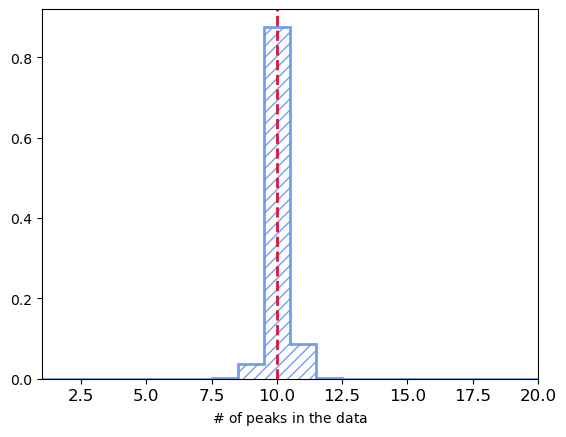

In [16]:
# get leaves from all steps after burn-in and remove higher temperature chains 
# this is the 0 index below
nleaves = ensemble.backend.get_nleaves()["pulse"][:, 0].flatten() 

bins = (np.arange(1, nleaves_max['pulse'] + 2) - 0.5)  # Get maximum allowed number of leaves for the given branch

plt.hist(
    nleaves,
    bins=bins,
    color='#6495ed',
    alpha=0.9,
    lw=2,
    histtype='step',
    density=True,
    hatch='///'
)

# injection line 

plt.axvline(x=int(npulses), linestyle='--', lw=2, color='#DC143C')
plt.xticks(fontsize=12)
plt.xlim(1, 20)
plt.xlabel("$\#$ of peaks in the data")

### Question:
Is this what you expected? Does RJMCMC tell us what the "right" answer is? How do you think the noise effects this posterior plot? If we increase the noise, what type of changes do we expect and why?

这是你所预计的吗？RJMCMC是否给出了“正确”的答案？你怎么理解这个后验分布的噪声效应？如果我们增加其中的噪声，你预计会发生什么变化，为什么？

Now we will look at the parameters of the recovered pulses to see how well we located the injected pulses. To do this, we are going to flatten all of samples from all leaf counts found, i.e. we will take every single source in the cold chain and plot all of these overlayed. **Hint**: use the `inds` array to your advantage here.

现在我们来看恢复脉冲的参数来了解如何定位注入脉冲。为了做到这一点，我们将从所有发现的叶子计数中获取所有样本，也就是说，我们将在冷链中获取每一个单一来源并绘制所有这些重叠的图。提示：在这里使用inds数组比较方便。

We recommend using `pandas` and `chainconsumer` to do this, but you can do it anyway you like. 

我们推荐使用pandas和chainconsumer来完成，但也可以按照自己的喜好来操作。

In [17]:
import pandas as pd

TypeError: 'numpy.float64' object cannot be interpreted as an integer

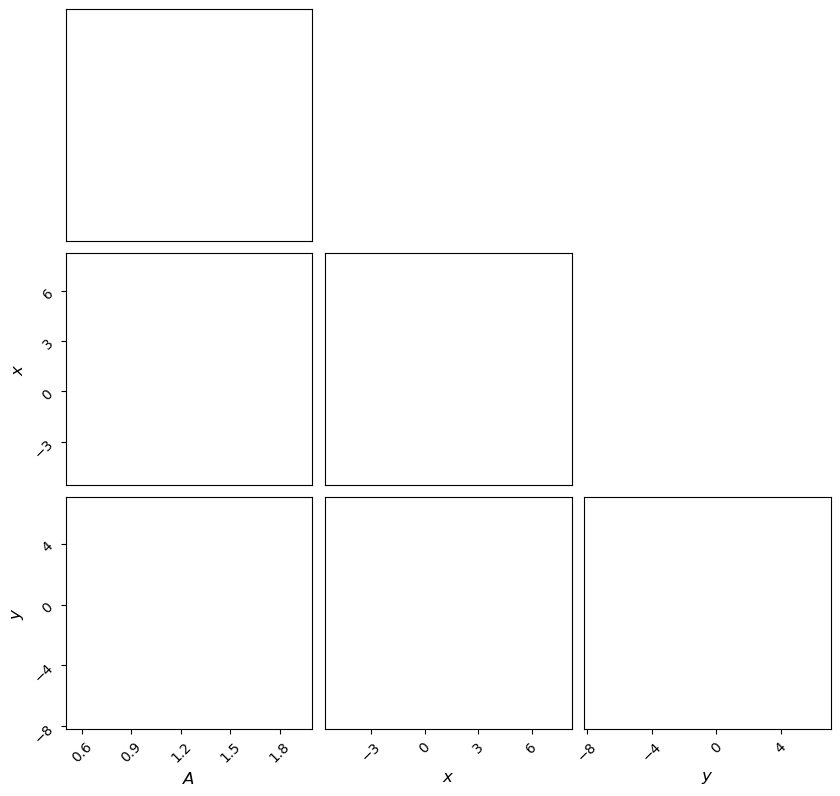

In [19]:
pulse_parameters = ["$A$", r"$x$", r"$y$"]

samples_pulses = ensemble.backend.get_chain()['pulse'][ensemble.backend.get_inds()["pulse"]]

df = pd.DataFrame({key: val for key, val in zip(pulse_parameters, samples_pulses.T)})
c = ChainConsumer()
check = int(3)
c.add_chain(Chain(samples=df, name="Test", smooth=check))
fig = c.plotter.plot()

### Question:
How did we do? Was it a success? Could there be improvements? 

我们是怎么处理的，它成功吗？是否有改进？

## Task 2: Model selection with RJMCMC RJMCMC下的模型选择

In this task, you will use RJMCMC to do a direct model comparison. This will be the same model comparison used in Tutorial 3 comparing a Gaussian pulse with a Cauchy pulse. In tutorial 3, we used fixed-dimensional MCMC and thermodynamic integration to estimate the evidence of each model. Then we compared them to get the Bayes Factor. Using RJMCMC will produce a posterior distribution on the model selection index rather than a direct evidence for each model. The fraction of walkers that have highlighted one model over the other represents a proxy for the odds ratio. This is not strictly true when one model is much more favored than another. However, when model favorability is close, this direct computation is okay. 

在本任务中，你将会使用RJMCMC进行直接的模型比较。这是教程3中使用过的相同的模型比较用于高斯脉冲和柯西脉冲。在教程3中，我们使用固定维数的MCMC和热力学积分来估计每个模型的证据。然后我们通过比较它们来得到贝叶斯因子。使用RJMCMC将产生模型选择指数的后验分布而非每个模型的直接证据。推进器中强调一种而非其他模式的比例代表了其优势比。当一种模式比另一种模式更受欢迎时这并不是严格正确的。然而当欢迎度相似时这样的直接计算是可以接受的。

For simplicity, we will consider the spread of the signal to be 1. Therefore, we are only fitting and comparing the amplitude and mean of the pulse. 

简单起见，我们考虑信号的扩散为1。因此我们只拟合和比较脉冲的振幅和平均值。

Once again, we will start by providing the functions for the Gaussian pulse, Cauchy pulse, and the Likelihood function. 

我们再次从为高斯脉冲，柯西脉冲提供方程开始，以及似然方程。

In [20]:
from scipy.stats import cauchy
def gaussian_pulse(x, a, b):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * 1.0 ** 2))
    return f_x

def cauchy_pulse(x, a, b):
    f_x = a * cauchy.pdf(x - b)
    return f_x

def log_like_fn(params, t, data, sigma, which_template):

    pulse_gen = gaussian_pulse if which_template == "gauss" else cauchy_pulse
    template = pulse_gen(t, *params)

    ll = -0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll

def log_like_wrap(params, *args):
    # must be careful about how these models are read into the Likelihood function
    # In this case, we will have one model with a single set of parameters 
    # and one model that is None
    
    assert len(params) == 2
    if params[0] is not None:
        assert params[1] is None
        # gauss will be first set of params
        args += ("gauss",)
        ll = log_like_fn(params[0][0], *args)

    else:
        assert params[0] is None
        # gauss will be first set of params
        args += ("cauchy",)
        ll = log_like_fn(params[1][0], *args)

    return ll

We will inject the Gausian pulse and compare to the Cauchy pulse.

我们将注入高斯脉冲并将其与柯西脉冲进行比较。

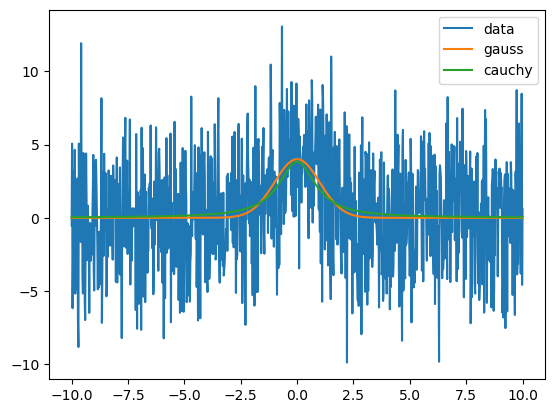

In [21]:
t_vals = np.linspace(-10.0, 10.0, 1000)
sigma = 3.5
amp_true = 4.0
mean_true = 0.0
true_data = gaussian_pulse(t_vals, amp_true, mean_true)
data = true_data + np.random.randn(*t_vals.shape) * sigma
cauchy_data = cauchy_pulse(t_vals, amp_true * 3, mean_true)
plt.plot(t_vals, data, label="data")
plt.plot(t_vals, true_data, label="gauss")
plt.plot(t_vals, cauchy_data, label="cauchy")
plt.legend()
# plt.plot(x_vals, np.exp(log_like_fn()))
# plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))

We will follow the same setup order as the last problem. Start with the basic declarations (`ntemps`, `ndims`, etc.). For this problem, the max leaves for both models should be 1 and the min leaves for both models should be 0. 

我们将使用和上一问题一样的安装顺序。从最基本声明开始。对于这个问题，两个模型的最大叶子数都为1，最小叶子数都为0。

In [22]:
ntemps = 10
nwalkers = 30

ndims        = {"gauss": 2, "cauchy": 2}           # The dimensions of the two models we sample for here (# of parameter for each pulse, and # of parameters for the noise)
nleaves_max  = {"gauss": 1, "cauchy": 1}   # Maximum number of components for each model type (noise is 1, because we don't want to use RJ MCMC on it).
nleaves_min = {"gauss": 0, "cauchy": 0}
branch_names = ["gauss", "cauchy"]


Now we will put together the priors for both models. The priors are identical really for the two models. The amplitude prior should span the injection values. The mean prior should span the domain of time.

现在我们将两个模型的先验放在一起。两个模型的先验应该相等。振幅先验应该在注入值展开。平均先验应该在时域展开。

In [23]:
priors = {}
priors["gauss"] = ProbDistContainer({
    0: uniform_dist(0.0, 40.0),
    1: uniform_dist(t_vals.min(), t_vals.max())
}) 

priors["cauchy"] = ProbDistContainer({
    0: uniform_dist(0.0, 40.0),
    1: uniform_dist(t_vals.min(), t_vals.max())
}) 

Now we will produce the same type of `GaussianMove` that we built earlier. We need to make sure that to provide a covariance for each model! So, it must be a dictionary with entries for both models. The entries can really be the same though. 

现在我们将生成与之前构建的相同类型的GaussianMove。我们需要为每个模型提供协方差。因此它必须是包含两个模型的项的字典。这些项可以是相同的。

In [24]:
factor = 0.01
cov    = {"gauss": np.diag(np.ones(2)) * factor, "cauchy": np.diag(np.ones(2)) * factor}
moves = GaussianMove(cov)

Instantiate the `EnsembleSampler`. 实例化EnsembleSampler

In [25]:
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    log_like_wrap,
    priors,
    nbranches=2,
    branch_names=branch_names,  # order determines order of parameter sets in Likelihood
    tempering_kwargs=dict(ntemps=ntemps, Tmax=np.inf),
    args=(t_vals, data, sigma),
    rj_moves=True,
    moves=moves,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min
)

Generate start points. **Note**: this is very important. This test will only work if:
* we have **2** models,
* each model has max leaves of 1 and min leaves of 0,
* and the starting points must all have **either** the Gaussian or Cauchy pulse, not both and not neither.

生成起始点。注意：这非常重要，测试仅在以下情况下有效：

有两个模型

每个模型最大叶子数为1最小叶子数为0

起始点必须有高斯脉冲或者柯西脉冲，不能没有或者都有

In this setup, each proposal will propose to switch the model and draw from its prior. 

在此设置中，每个提案将提议切换模型并从其先验模型中提取。

Generate your start point and use the `inds` array to tell the sampler that each walker has only one model instance. 

生成起点并用inds数组来使采样器中每个推进器只有一个模型实例。

In [26]:
start_point = {name: priors[name].rvs(size=(ntemps, nwalkers, 1)) for name in branch_names}

# draw randomly which model to start in 
model_index = np.random.randint(0, 2, size=(ntemps, nwalkers, 1))

inds = {name: np.zeros((ntemps, nwalkers, 1), dtype=bool) for name in branch_names}

inds["gauss"][model_index == 0] = True
inds["cauchy"][model_index == 1] = True

assert np.all(inds["gauss"].astype(int) + inds["cauchy"].astype(int) == 1)
start_state = State(start_point, inds=inds)


Run the sampler with a burn-in.

运行带点燃值的采样器。

In [27]:
nteps = 500
sampler.run_mcmc(start_state, nsteps, progress=True, burn=100)

100%|██████████| 5000/5000 [03:36<00:00, 23.13it/s]


To find our posterior odds ratio, we need to get the fraction of cold-chain samples that exist in one of the two states. Calculate the odds ratio.

为了求出后验比值比，我们需要得到存在于其中一种态的冷链样本的比例。计算优势比。

In [28]:
nleaves = sampler.get_nleaves()

In [29]:
# number of cold-chain Gaussians / number of cold-chain samples
nleaves["gauss"][:, 0].sum() / np.prod(nleaves["gauss"][:, 0].shape)

0.8738866666666667

### Question:
If we change the noise, what effect will this have on our results? What happens when one model is heavily favored so that the fraction is 1? Is this a proper estimate of the odds ratio? What could we do in this case where the initial odds ratio is 1 to actually estimate the odds ratio?

如果我们改变噪声，这会对我们的结果产生什么影响？当一种模式的占比为1时会发生什么？这是对优势比的正确估计吗？在初始优势比为1的时候我们应该做什么去估计优势比呢？